In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits
from lightkurve import KeplerTargetPixelFile
from lightkurve import SimpleKeplerPRF, PRFPhotometry, SceneModel
from lightkurve import KeplerLightCurve
from lightkurve.utils import KeplerQualityFlags
from lightkurve import KeplerCBVCorrector
from oktopus import UniformPrior
from astropy.stats import LombScargle

In [2]:
tpf = KeplerTargetPixelFile('../Data/ktwo237780335-c111_lpd-targ.fits')

In [3]:
tpf.interact()

Loading BokehJS ...

Output()

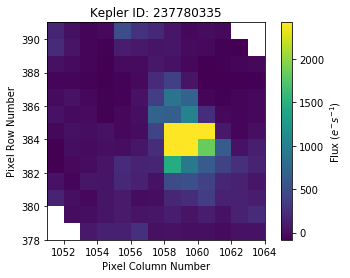

In [4]:
tpf.plot(frame=100, interpolation='nearest')

In [5]:
prf = SimpleKeplerPRF(channel=tpf.channel, shape=tpf.shape[1:], column=tpf.column, row=tpf.row)

In [6]:
scene = SceneModel(prfs=[prf])

In [7]:
prior = UniformPrior(lb=[1500., 1058., 382., 0.],
                     ub=[100000., 1061., 385., 1250.])

In [8]:
prior.mean

array([50750. ,  1059.5,   383.5,   625. ])

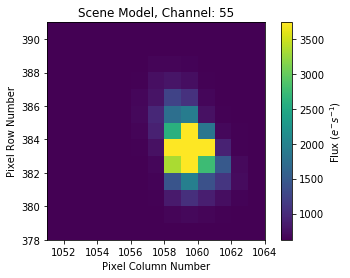

In [9]:
scene.plot(*prior.mean,interpolation='nearest')

In [10]:
phot = PRFPhotometry(scene_model=scene, prior=prior)

In [11]:
tpf.flux_bkg

array([[[      nan,       nan, 636.30634, ..., 636.96643, 637.0689 ,
         637.1759 ],
        [      nan, 636.3525 , 636.4143 , ..., 637.0655 , 637.1668 ,
         637.27264],
        [636.408  , 636.4645 , 636.5252 , ..., 637.16754, 637.26776,
         637.37244],
        ...,
        [637.41583, 637.4638 , 637.51605, ..., 638.08905, 638.1805 ,
         638.2763 ],
        [637.5544 , 637.6014 , 637.6526 , ..., 638.21716, 638.30743,
               nan],
        [637.69574, 637.7417 , 637.7919 , ..., 638.348  ,       nan,
               nan]],

       [[      nan,       nan, 637.5447 , ..., 638.22614, 638.3314 ,
         638.4412 ],
        [      nan, 637.5934 , 637.6578 , ..., 638.33057, 638.4347 ,
         638.5434 ],
        [637.6514 , 637.7105 , 637.77386, ..., 638.4379 , 638.541  ,
         638.64856],
        ...,
        [638.7002 , 638.751  , 638.8061 , ..., 639.4025 , 639.49695,
         639.5958 ],
        [638.84393, 638.89374, 638.9478 , ..., 639.53595, 639.62933,
   

In [12]:
newtpf = tpf.flux + tpf.flux_bkg

In [13]:
results = phot.fit(newtpf)

  0%|          | 0/1061 [00:00<?, ?it/s]/anaconda3/lib/python3.6/site-packages/scipy/optimize/optimize.py:1927: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
  3%|▎         | 37/1061 [00:00<00:15, 67.78it/s]/anaconda3/lib/python3.6/site-packages/autograd/tracer.py:48: RuntimeWarning: invalid value encountered in log
  return f_raw(*args, **kwargs)
100%|██████████| 1061/1061 [00:15<00:00, 67.49it/s]


In [14]:
flux = results[:, 0]
xc = results[:, 1]
yc = results[:, 2]
bkg = results[:, 3]

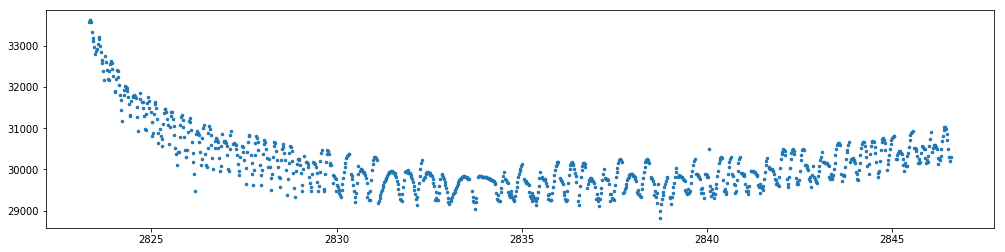

In [15]:
plt.figure(figsize=[17, 4])
plt.plot(tpf.time, flux, 'o', markersize=2.5)

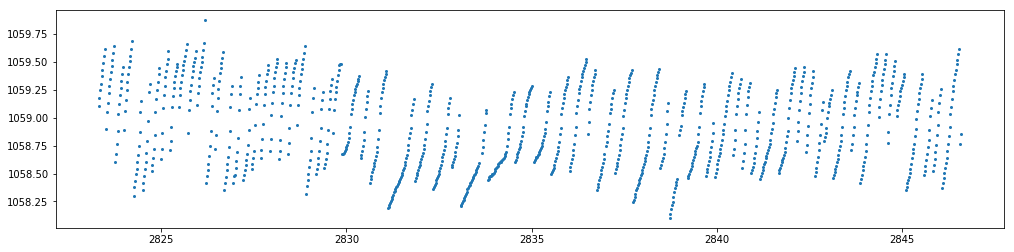

In [16]:
plt.figure(figsize=[17, 4])
plt.plot(tpf.time, xc, 'o', markersize=2)

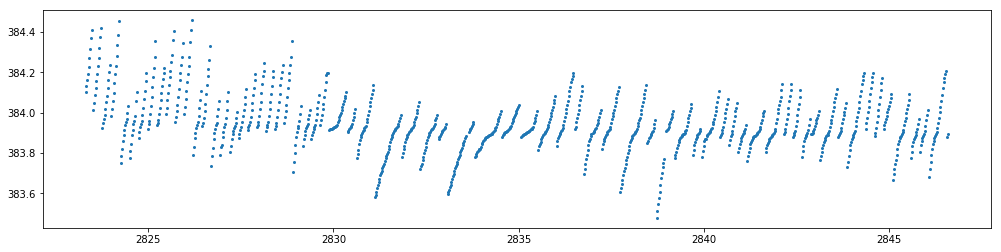

In [17]:
plt.figure(figsize=[17, 4])
plt.plot(tpf.time, yc, 'o', markersize=2)

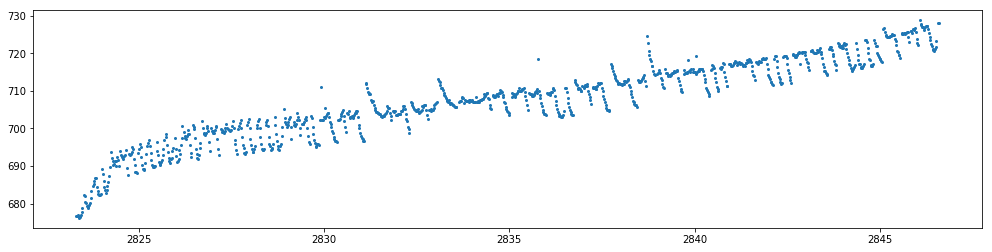

In [18]:
plt.figure(figsize=[17, 4])
plt.plot(tpf.time,bkg,'o',markersize=2)

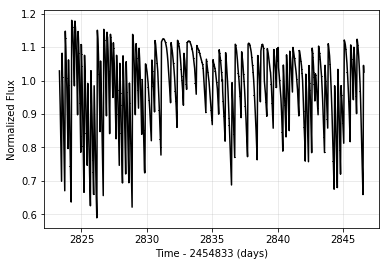

In [19]:
lc = tpf.to_lightcurve(aperture_mask='pipeline')
lc.plot()

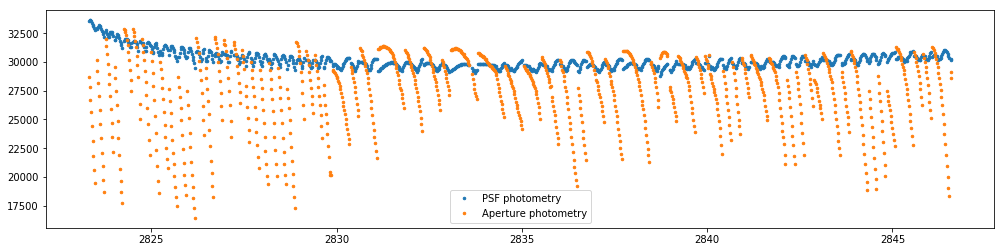

In [20]:
plt.figure(figsize=[17, 4])
plt.plot(tpf.time, flux, 'o', markersize=2.5, label='PSF photometry')
plt.plot(tpf.time, lc.flux, 'o', markersize=2.5, label='Aperture photometry')
plt.legend()

In [21]:
lc_psf=KeplerLightCurve(time=tpf.time, flux=flux, flux_err=lc.flux_err)

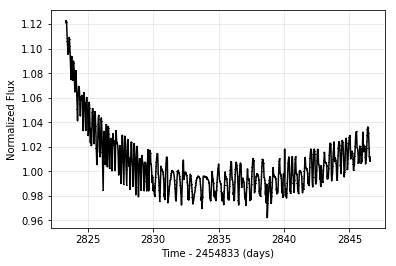

In [22]:
lc_psf.plot()

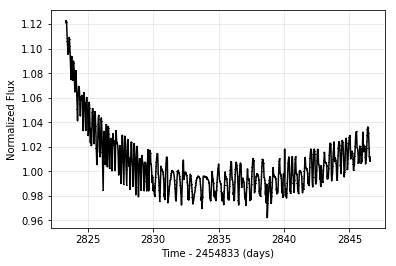

In [23]:
lc_psf = lc_psf.remove_nans().remove_outliers()
lc_psf.plot()

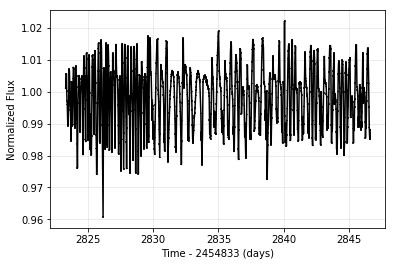

In [24]:
lc_psf.flatten().plot()

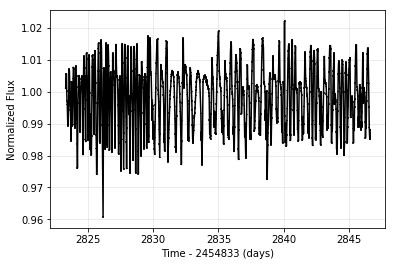

In [25]:
lc_flat = lc_psf.flatten()
lc_flat.plot()

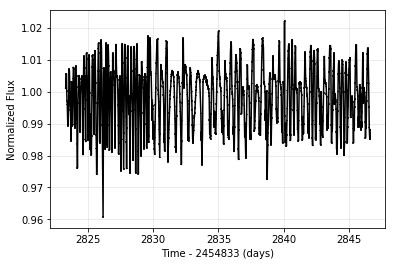

In [26]:
lc_flat = lc_flat.remove_nans().remove_outliers()
lc_flat.plot()

In [27]:
t = lc_psf.time
y = lc_psf.flux

In [32]:
frequency, power = LombScargle(t,y).autopower(minimum_frequency=0.66, maximum_frequency=10)
p = 1/frequency[np.argmax(power)]
print(p)

1.422535336550663


In [33]:
LombScargle(t,y).false_alarm_probability(power.max(), method='bootstrap')

0.89

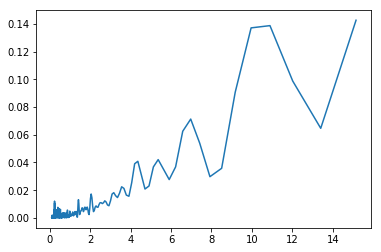

In [29]:
plt.plot(1/frequency, power)

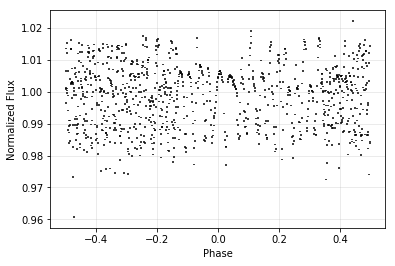

In [30]:
lc_fold = lc_flat.fold(period=p)
lc_fold.plot(linestyle='none')

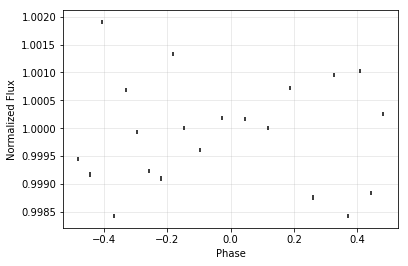

In [31]:
lc_fold.bin(50).plot(linestyle='none')